# Bibliothèques et base de données

In [5]:
!pip install pandarallel bs4 transformers

In [6]:
# import the libraries
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re, string
import nltk
import spacy
from pandarallel import pandarallel
import seaborn as sns
pandarallel.initialize(progress_bar=True, nb_workers=6)

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [7]:
#Chargement des jeux de données
df_train=pd.read_csv("/content/drive/MyDrive/tweet_data/train.csv")
df_test=pd.read_csv("/content/drive/MyDrive/tweet_data/test.csv")
df_submit=pd.read_csv('/content/drive/MyDrive/tweet_data/sample_submission.csv')

In [8]:
#Informations sur les bases de données:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [9]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [11]:
# Valeurs manquantes train
df_train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [12]:
# Valeurs manquantes test
df_test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [13]:
df_submit.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


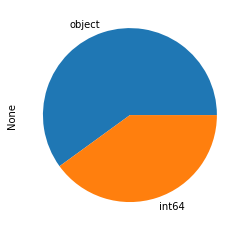

In [14]:
df_train.dtypes.value_counts().plot(kind="pie")

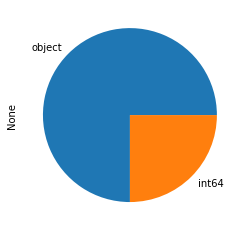

In [15]:
df_test.dtypes.value_counts().plot(kind="pie")

In [16]:
# check the duplicated data
df_train.duplicated().sum()

0

In [17]:
df_train[['location', 'text', 'target']].duplicated().sum()

70

Nous avons au total 70 Doublons dans notre dataset. Nous allons les supprimer

In [18]:
print(df_train.shape)
df_train.drop_duplicates(subset=['location', 'text', 'target'], inplace=True)
print(df_train.shape)

(7613, 5)
(7543, 5)


## Visualisation de l'équilibre de la dataset

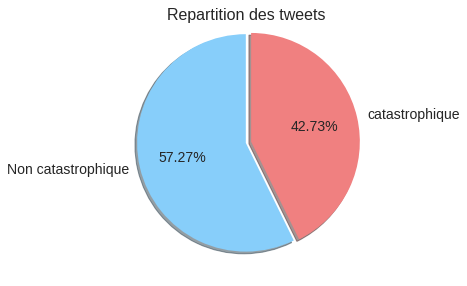

In [19]:
# set the figure size
plt.figure(figsize=(9, 5))

# set the style
plt.style.use('seaborn-darkgrid')

# set the colors
colors = ['lightskyblue', 'lightcoral']

# generate a pie plot
plt.pie(df_train['target'].value_counts(), explode=(0, 0.05), labels=["Non catastrophique", "catastrophique"], 
        autopct="%0.2f%%", textprops={'fontsize': 14}, shadow=True, startangle=90, colors=colors)

# add a title
plt.title('Repartition des tweets', size=16, y=0.93)

# show the plot
plt.show()

Donc la dataset est presque équilibré.

### Word Clouds  Avec le test brut

Let's visualize the unprocessed text as a word cloud. The size of text shows the frequency that the word appears in the dataset.

In [20]:
# Définition du random state
random_state = 4041

# bibliothèque
from wordcloud import WordCloud

# concat all the text for each labels
non_disaster_text = [''.join(t) for t in df_train[df_train['target']==0]['text']]
non_disaster_strings = ' '.join(map(str, non_disaster_text))
disaster_text = [''.join(t) for t in df_train[df_train['target']==1]['text']]
disaster_strings = ' '.join(map(str, disaster_text))

# generate word clouds
non_disaster_cloud = WordCloud(width=800, height=400, max_words=500, background_color='white', random_state=random_state).generate(non_disaster_strings)
disaster_cloud = WordCloud(width=800, height=400, max_words=500, random_state=random_state).generate(disaster_strings)

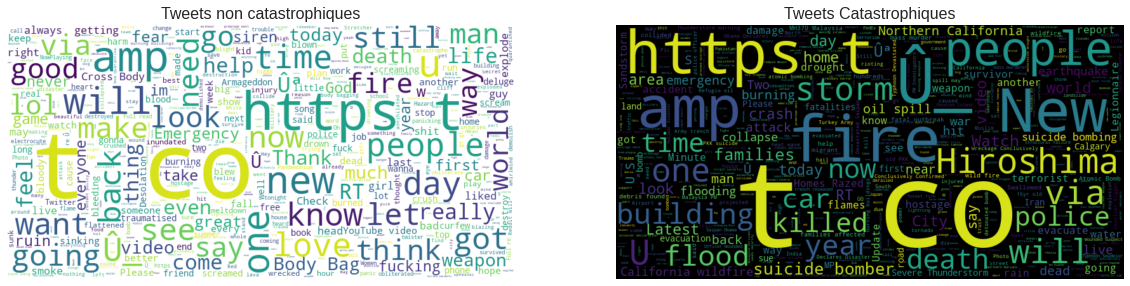

In [21]:
# create subplots for the generated clouds
fig, axes = plt.subplots(1, 2, figsize = (20,20))
axes[0].imshow(non_disaster_cloud, interpolation='bilinear')
axes[1].imshow(disaster_cloud, interpolation='bilinear')

# turn the axis off
[ax.axis('off') for ax in axes]

# add titles
axes[0].set_title('Tweets non catastrophiques', fontsize=16)
axes[1].set_title('Tweets Catastrophiques', fontsize=16)

# Affichage de la figure
plt.show()

Nous pouvons reconnaître certains mots liés à une catastrophe (par exemple, « incendie », « inondation » et « tempête »), mais la différence entre les Tweets de catastrophe et non liés à une catastrophe n'est pas facile à faire. Des mots comme "t" et "co" (reflétant des liens raccourcis sur Twitter) dominent les nuages de mots, mais ne fournissent pas beaucoup de sens utile. **Comparons-les plus tard avec des nuages ​​de mots de données prétraitées.**


# Traitement du text

In [22]:
df_train.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

***

## <a id="preprocess1">🧾 Text Preprocessing - Part I</a>

Let's start preprocessing our text by removing the parts below: 
- URLs
- HTML tags
- character references
- non-printable characters
- numeric values

We'll come back to the preprocessing step after creating some new features.

### Remove URLs

In [23]:
# define a function that removes URLs from the text
def remove_url(text):
    text = re.sub(r'((?:https?|ftp|file)://[-\w\d+=&@#/%?~|!:;\.,]*)', '', text)
    return text

# remove URLs from the text and show the modified text in a new column
df_train['text_cleaned'] = df_train['text'].apply(remove_url)
df_test['text_cleaned'] = df_test['text'].apply(remove_url)

### Remove HTML tags

In [24]:
# define a function that removes HTML tags
def remove_HTML(text):
    text = re.sub(r'<.*?>', '', text)
    return text

# remove HTML tags
df_train['text_cleaned'] = df_train['text_cleaned'].apply(remove_HTML)
df_test['text_cleaned'] = df_test['text_cleaned'].apply(remove_HTML)

### Remove Character References

In [25]:
# define a function to remove character references (e.g., &lt;, &amp;, &nbsp;)
def remove_references(text):
    text = re.sub(r'&[a-zA-Z]+;?', '', text)
    return text

# remove character references
df_train['text_cleaned'] = df_train['text_cleaned'].apply(remove_references)
df_test['text_cleaned'] = df_test['text_cleaned'].apply(remove_references)

### Remove Non-printable Characters

In [26]:
# check which characters are printable (ASCII)
string.printable

'0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ \t\n\r\x0b\x0c'

In [27]:
# define a function that removes non-printable characters
def remove_non_printable(text):
    text = ''.join([word for word in text if word in string.printable])
    return text

# remove non-printable characters
df_train['text_cleaned'] = df_train['text_cleaned'].apply(remove_non_printable)
df_test['text_cleaned'] = df_test['text_cleaned'].apply(remove_non_printable)

### Remove Numeric Values
Remove numeric values, including mixtures of alphabetical characters and numeric values such as 'M194', '5km'.

In [28]:
# define a function that removes numeric values and mixtures
def remove_num(text):
    text = re.sub(r'\w*\d+\w*', '', text)
    return text

# remove numeric values and mixtures
df_train['text_cleaned'] = df_train['text_cleaned'].apply(remove_num)
df_test['text_cleaned'] = df_test['text_cleaned'].apply(remove_num)

In [29]:
# check the results
df_train.tail()

,id,keyword,location,text,target,text_cleaned
7605,10864,NaN,NaN,on the flip side I'm at Walmart and there is a...,1,on the flip side I'm at Walmart and there is a...
7606,10866,NaN,NaN,Suicide bomber kills 15 in Saudi security site...,1,Suicide bomber kills in Saudi security site m...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,Two giant cranes holding a bridge collapse int...
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,Police investigating after an e-bike collided ...
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1,The Latest: More Homes Razed by Northern Calif...


In [30]:
# check the results
df_test.tail()

,id,keyword,location,text,text_cleaned
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,EARTHQUAKE SAFETY LOS ANGELES SAFETY FASTENER...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,Storm in RI worse than last hurricane. My har...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,Green Line derailment in Chicago
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,MEG issues Hazardous Weather Outlook (HWO)
3262,10875,NaN,NaN,#CityofCalgary has activated its Municipal Eme...,#CityofCalgary has activated its Municipal Eme...


## <a id="engineer">📐 Feature Engineering</a>

Below are 10 features we're going to create:

- Number of **sentences**
- Number of **words**
- Number of **characters**
- Number of **hashtags**
- Number of **mentions**
- Number of **all caps words**
- Average **length of words**
- Number of **proper nouns (PROPN)**
- Number of **non-proper nouns (NOUN)**
- Percentage of characters that are **punctuation**


### Number of Sentences

In [31]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [32]:
# create a new feature for the number of sentences in each Tweet
df_train['sent_count'] = df_train['text'].apply(nltk.tokenize.sent_tokenize).apply(len)
df_test['sent_count'] = df_test['text'].apply(nltk.tokenize.sent_tokenize).apply(len)

### Number of Words

In [33]:
# create a new feature for the number of words
df_train['word_count'] = df_train['text'].apply(nltk.tokenize.word_tokenize).apply(len)
df_test['word_count'] = df_test['text'].apply(nltk.tokenize.word_tokenize).apply(len)

### Number of Characters

In [34]:
# create a new feature for the number of characters excluding white spaces
df_train['char_count'] = df_train['text'].apply(lambda x: len(x) - x.count(" "))
df_test['char_count'] = df_test['text'].apply(lambda x: len(x) - x.count(" "))

### Number of Hashtags

In [35]:
# define a function that returns the number of hashtags in a string
def hash_count(string):
    words = string.split()
    hashtags = [w for w in words if w.startswith('#')]
    return len(hashtags)

# create a new feature for the number of hashtags
df_train['hash_count'] = df_train['text'].apply(hash_count)
df_test['hash_count'] = df_test['text'].apply(hash_count)

### Number of Mentions

In [36]:
# define a function that returns the number of mentions in a string
def ment_count(string):
    words = string.split()
    mentions = [w for w in words if w.startswith('@')]
    return len(mentions)

# create a new feature for the number of mentions
df_train['ment_count'] = df_train['text'].apply(ment_count)
df_test['ment_count'] = df_test['text'].apply(ment_count)

### Number of All Caps Words

In [37]:
# define a function that returns the number of words in all CAPS
def all_caps_count(string):
    words = string.split()
    pattern = re.compile(r'\b[A-Z]+[A-Z]+\b')
    capsWords = [w for w in words if w in re.findall(pattern, string)]
    return len(capsWords)

# create a new feature for the number of words in all CAPS
df_train['all_caps_count'] = df_train['text'].apply(all_caps_count)
df_test['all_caps_count'] = df_test['text'].apply(all_caps_count)

### Average Length of words

In [38]:
# define a function that returns the average length of words
def avg_word_len(string):
    words = string.split()
    total_len = sum([len(words[i]) for i in range(len(words))])
    avg_len = round(total_len / len(words), 2)
    return avg_len

# create a new feature for the average length of words
df_train['avg_word_len'] = df_train['text'].apply(avg_word_len)
df_test['avg_word_len'] = df_test['text'].apply(avg_word_len)

### Number of Proper Nouns (PROPN)
It is known that fake news tends to use more proper nouns than real news ([this article](https://arxiv.org/pdf/1703.09398.pdf) is a great resource to learn about how NLP helps us detect the fake news). Would the number of proper nouns in Tweets tell us anything about whether a given Tweet is an actual disaster-related Tweet or not? Let's try it out.

In [39]:
# define a function using nltk that returns the number of proper nouns in the text
def propn_count_nltk(text):    
    tokens = nltk.word_tokenize(text)
    tagged = [token for token in nltk.pos_tag(tokens)]
    propn_count = len([token for (token, tag) in tagged if tag == 'NNP' or tag == 'NNPS'])
    return propn_count

# create a new feature for the number of proper nouns
df_train['propn_count_nltk'] = df_train['text'].apply(propn_count_nltk)
df_test['propn_count_nltk'] = df_test['text'].apply(propn_count_nltk)

In [40]:
# check the results
df_train[['id', 'text', 'text_cleaned', 'propn_count_nltk']].head()

,id,text,text_cleaned,propn_count_nltk
0,1,Our Deeds are the Reason of this #earthquake M...,Our Deeds are the Reason of this #earthquake M...,4
1,4,Forest fire near La Ronge Sask. Canada,Forest fire near La Ronge Sask. Canada,5
2,5,All residents asked to 'shelter in place' are ...,All residents asked to 'shelter in place' are ...,0
3,6,"13,000 people receive #wildfires evacuation or...",", people receive #wildfires evacuation orders ...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,Just got sent this photo from Ruby #Alaska as ...,2


Looking at the results, we can easily tell **nltk** did not do a good job detecting proper nouns here. The first text, "Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all" doesn't seem to have 4 proper nouns. Let's check which tokens were tagged as proper nouns.

In [41]:
# test how nltk worked with the first text
string = "Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all"
print([(token, tag) for (token, tag) in nltk.pos_tag(nltk.word_tokenize(string)) if tag == 'NNP'])

[('Reason', 'NNP'), ('May', 'NNP'), ('ALLAH', 'NNP'), ('Forgive', 'NNP')]


Les noms non propres commençant par une majuscule ont été étiquetés comme noms propres ! Aurait-il été correctement étiqueté si la chaîne avait d'abord été convertie en minuscules ?

In [42]:
# test how nltk works with the first text after lowercasing it
string = "Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all"
print([(token, tag) for (token, tag) in nltk.pos_tag(nltk.word_tokenize(string.lower())) if tag == 'NNP'])

[]


No, now with the lowercased text, nltk does not tag "allah" as a proper noun. Let's try with **spaCy** this time.

In [43]:
# load the model
nlp = spacy.load('en_core_web_sm')

# check the same string with spaCy
string = "Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all"
print([(token.text, token.pos_) for token in nlp(string) if token.pos_=='PROPN'])

[('ALLAH', 'PROPN')]


SpaCy correctly picked up the proper noun from the string. Let's create the feature of the number of proper nouns in the text with spaCy and remove the one we previously created with nltk.

In [44]:
# define a function that returns number of proper nouns with spaCy
def propn_count(text, model=nlp):
    doc = model(text)
    pos = [token.pos_ for token in doc]
    return pos.count('PROPN')

# create a new feature for numbers of proper nouns
df_train['propn_count'] = df_train['text'].apply(propn_count)
df_test['propn_count'] = df_test['text'].apply(propn_count)

In [45]:
# remove 'propn_count_nltk' columns
df_train = df_train.drop(['propn_count_nltk'], axis=1)
df_test = df_test.drop(['propn_count_nltk'], axis=1)

In [46]:
# check the results
df_train[['id', 'text', 'text_cleaned', 'propn_count']].head()

,id,text,text_cleaned,propn_count
0,1,Our Deeds are the Reason of this #earthquake M...,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,Forest fire near La Ronge Sask. Canada,4
2,5,All residents asked to 'shelter in place' are ...,All residents asked to 'shelter in place' are ...,0
3,6,"13,000 people receive #wildfires evacuation or...",", people receive #wildfires evacuation orders ...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,Just got sent this photo from Ruby #Alaska as ...,2


SpaCy is not perfect, either - "La Ronge" in the second text (id:4) is one proper noun not two, but it is clear that spaCy still performs better than nltk on this specific task. Let's use spaCy for the next feature as well. 

### Number of Non-proper Nouns (NOUN)

In [47]:
# define a function that returns number of non-proper nouns
def noun_count(text, model=nlp):
    doc = model(text)
    pos = [token.pos_ for token in doc]
    return pos.count('NOUN')

# create a new feature for numbers of non-proper nouns
df_train['noun_count'] = df_train['text'].parallel_apply(noun_count)
df_test['noun_count'] = df_test['text'].parallel_apply(noun_count)

### Percentage of Characters that are Punctuation

In [48]:
import string

# define a function that returns the percentage of punctuation
def punc_per(text):
    total_count = len(text) - text.count(" ")
    punc_count = sum([1 for c in text if c in string.punctuation])
    if punc_count != 0 and total_count != 0:
        return round(punc_count / total_count * 100, 2)
    else:
        return 0

# create a new feature for the percentage of punctuation in text
df_train['punc_per'] = df_train['text'].apply(punc_per)
df_test['punc_per'] = df_test['text'].apply(punc_per)

In [49]:
# check the results
df_train.tail()

,id,keyword,location,text,target,text_cleaned,sent_count,word_count,char_count,hash_count,ment_count,all_caps_count,avg_word_len,propn_count,noun_count,punc_per
7605,10864,NaN,NaN,on the flip side I'm at Walmart and there is a...,1,on the flip side I'm at Walmart and there is a...,1,27,89,0,0,0,3.42,1,2,1.12
7606,10866,NaN,NaN,Suicide bomber kills 15 in Saudi security site...,1,Suicide bomber kills in Saudi security site m...,1,22,102,0,0,0,5.10,5,5,10.78
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,Two giant cranes holding a bridge collapse int...,1,13,73,0,0,0,6.64,0,5,6.85
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,Police investigating after an e-bike collided ...,2,21,119,0,0,0,6.26,2,8,4.20
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1,The Latest: More Homes Razed by Northern Calif...,1,16,82,0,0,1,6.31,5,2,8.54


In [50]:
# check the results
df_test.tail()

,id,keyword,location,text,text_cleaned,sent_count,word_count,char_count,hash_count,ment_count,all_caps_count,avg_word_len,propn_count,noun_count,punc_per
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,EARTHQUAKE SAFETY LOS ANGELES SAFETY FASTENER...,1,8,48,0,0,6,6.00,5,1,0.00
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,Storm in RI worse than last hurricane. My har...,4,30,117,0,0,1,5.09,1,6,4.27
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,Green Line derailment in Chicago,1,8,50,0,0,0,8.33,3,2,10.00
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,MEG issues Hazardous Weather Outlook (HWO),1,11,59,0,0,1,8.43,5,2,11.86
3262,10875,NaN,NaN,#CityofCalgary has activated its Municipal Eme...,#CityofCalgary has activated its Municipal Eme...,2,11,61,2,0,0,7.62,4,0,4.92


***

***

## <a id="preprocess2">🧾 Text Preprocessing - Part II</a>
Let's resume our text preprocessing and **lemmatize** the text and make it **lowercase**. We'll also **remove repeated characters in elongated words, as well as mentions, stopwords, and punctuation**. We'll keep hashtags as they may provide valuable insights in this particular project. 

### Lemmatization

In [51]:
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, nb_workers=6)

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [52]:
# lemmatize the text
df_train['text_cleaned'] = df_train['text_cleaned'].parallel_apply(lambda x:' '.join([t.lemma_ for t in nlp(x)]))
df_test['text_cleaned'] = df_test['text_cleaned'].parallel_apply(lambda x:' '.join([t.lemma_ for t in nlp(x)]))

### Convert the Text to Lowercase

In [53]:
# lowercase the text
df_train['text_cleaned'] = [t.lower() for t in df_train['text_cleaned']]
df_test['text_cleaned'] = [t.lower() for t in df_test['text_cleaned']]

### Remove Repeated Charcters in Elongated Words

In [54]:
# define a function that removes repeated characters in elongated words
def remove_repeated(text):
    elongated = re.compile(r'(\S*?)([a-z])\2{2,}')
    text = elongated.sub(r'\1\2', text)
    return text

# remove repeated characters in elongated words
df_train['text_cleaned'] = df_train['text_cleaned'].apply(remove_repeated)
df_test['text_cleaned'] = df_test['text_cleaned'].apply(remove_repeated)

### Remove Mentions

In [55]:
# define a function that removes mentions
def remove_mention(text):
    text = re.sub(r'@\w+', '', text)
    return text

# remove mentions
df_train['text_cleaned'] = df_train['text_cleaned'].apply(remove_mention)
df_test['text_cleaned'] = df_test['text_cleaned'].apply(remove_mention)

### Remove Stopwords

In [56]:
# define a function that removes stopwords
def remove_stopwords(text):
    stopwords = nlp.Defaults.stop_words
    text_nostop = ' '.join([token for token in text.split() if token not in stopwords])
    return text_nostop

# remove stopwords
df_train['text_cleaned'] = df_train['text_cleaned'].apply(remove_stopwords)
df_test['text_cleaned'] = df_test['text_cleaned'].apply(remove_stopwords)

### Remove Punctuation

In [57]:
# define a function to remove punctuation
def remove_punct(text):
    punct = string.punctuation
    text_nospunct = ' '.join([token for token in text.split() if token not in punct])
    return text_nospunct

# remove punctuation
df_train['text_cleaned'] = df_train['text_cleaned'].apply(remove_punct)
df_test['text_cleaned'] = df_test['text_cleaned'].apply(remove_punct)

In [58]:
# check the results
df_train[['id', 'text', 'text_cleaned']].head()

,id,text,text_cleaned
0,1,Our Deeds are the Reason of this #earthquake M...,deed reason earthquake allah forgive
1,4,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,5,All residents asked to 'shelter in place' are ...,resident ask shelter place notify officer evac...
3,6,"13,000 people receive #wildfires evacuation or...",people receive wildfire evacuation order calif...
4,7,Just got sent this photo from Ruby #Alaska as ...,got send photo ruby alaska smoke wildfire pour...


In [59]:
# check the results
df_test[['id', 'text', 'text_cleaned']].head()

,id,text,text_cleaned
0,0,Just happened a terrible car crash,happen terrible car crash
1,2,"Heard about #earthquake is different cities, s...",hear earthquake different city stay safe
2,3,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese flee street save
3,9,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfire
4,11,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill china taiwan


### Raw vs. Preprocessed Text with Word Clouds

Let's generate word clouds of preprocessed text.

In [60]:
from wordcloud import WordCloud
random_state=123
# concat all the preprocessed text for both labels
non_disaster_processed = [''.join(t) for t in df_train[df_train['target']==0]['text_cleaned']]
non_disaster_processed_s = ' '.join(map(str, non_disaster_processed))
disaster_processed = [''.join(t) for t in df_train[df_train['target']==1]['text_cleaned']]
disaster_processed_s = ' '.join(map(str, disaster_processed))

# generate word clouds of the preprocessed text
non_disaster_processed_wc = WordCloud(width=800, height=400, max_words=500, background_color='white', random_state=random_state).generate(non_disaster_processed_s)
disaster_processed_wc = WordCloud(width=800, height=400, max_words=500, random_state=random_state).generate(disaster_processed_s)

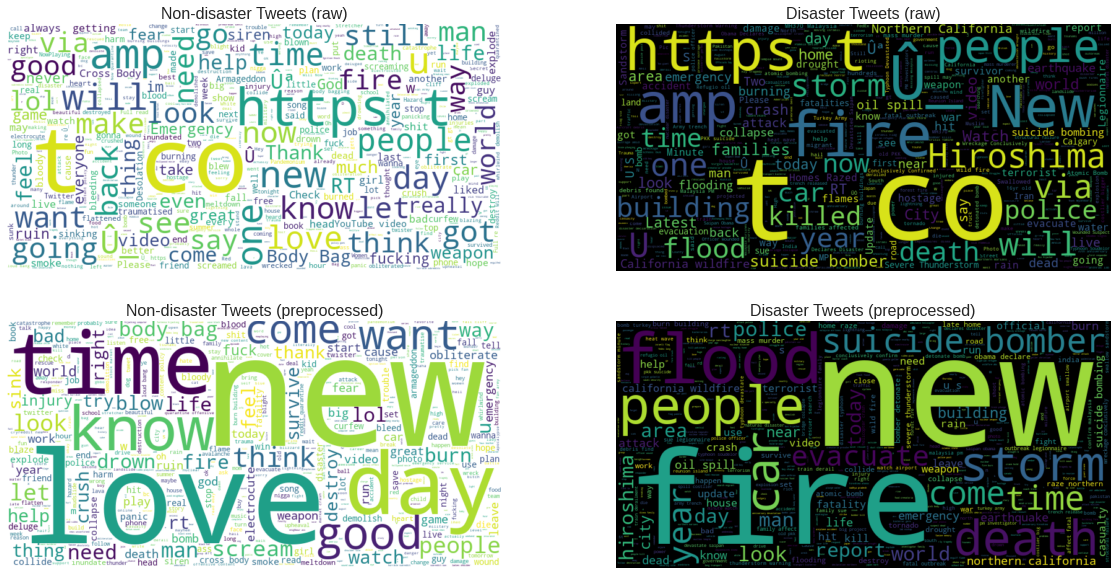

In [61]:
# create subplots for the generated clouds
fig, axes = plt.subplots(2, 2, figsize = (20,10))
axes[0,0].imshow(non_disaster_cloud, interpolation='bilinear')
axes[0,1].imshow(disaster_cloud, interpolation='bilinear')
axes[1,0].imshow(non_disaster_processed_wc, interpolation='bilinear')
axes[1,1].imshow(disaster_processed_wc, interpolation='bilinear')

# turn the axis off
[ax.axis('off') for ax in axes.ravel()]

# add titles
axes[0,0].set_title('Non-disaster Tweets (raw)', fontsize=16)
axes[0,1].set_title('Disaster Tweets (raw)', fontsize=16)
axes[1,0].set_title('Non-disaster Tweets (preprocessed)', fontsize=16)
axes[1,1].set_title('Disaster Tweets (preprocessed)', fontsize=16)

# show the figure
plt.show()

Now it's easier to see the frequently used words that actually are meaningful. It also seems like **more disaster-related words are showing on the word cloud of real disaster Tweets**.

### 📊 Visualizing Differences
Let's visualize some of the features we've created and see if there are easy-to-tell differences between disaster and non-disaster Tweets in our training dataset.

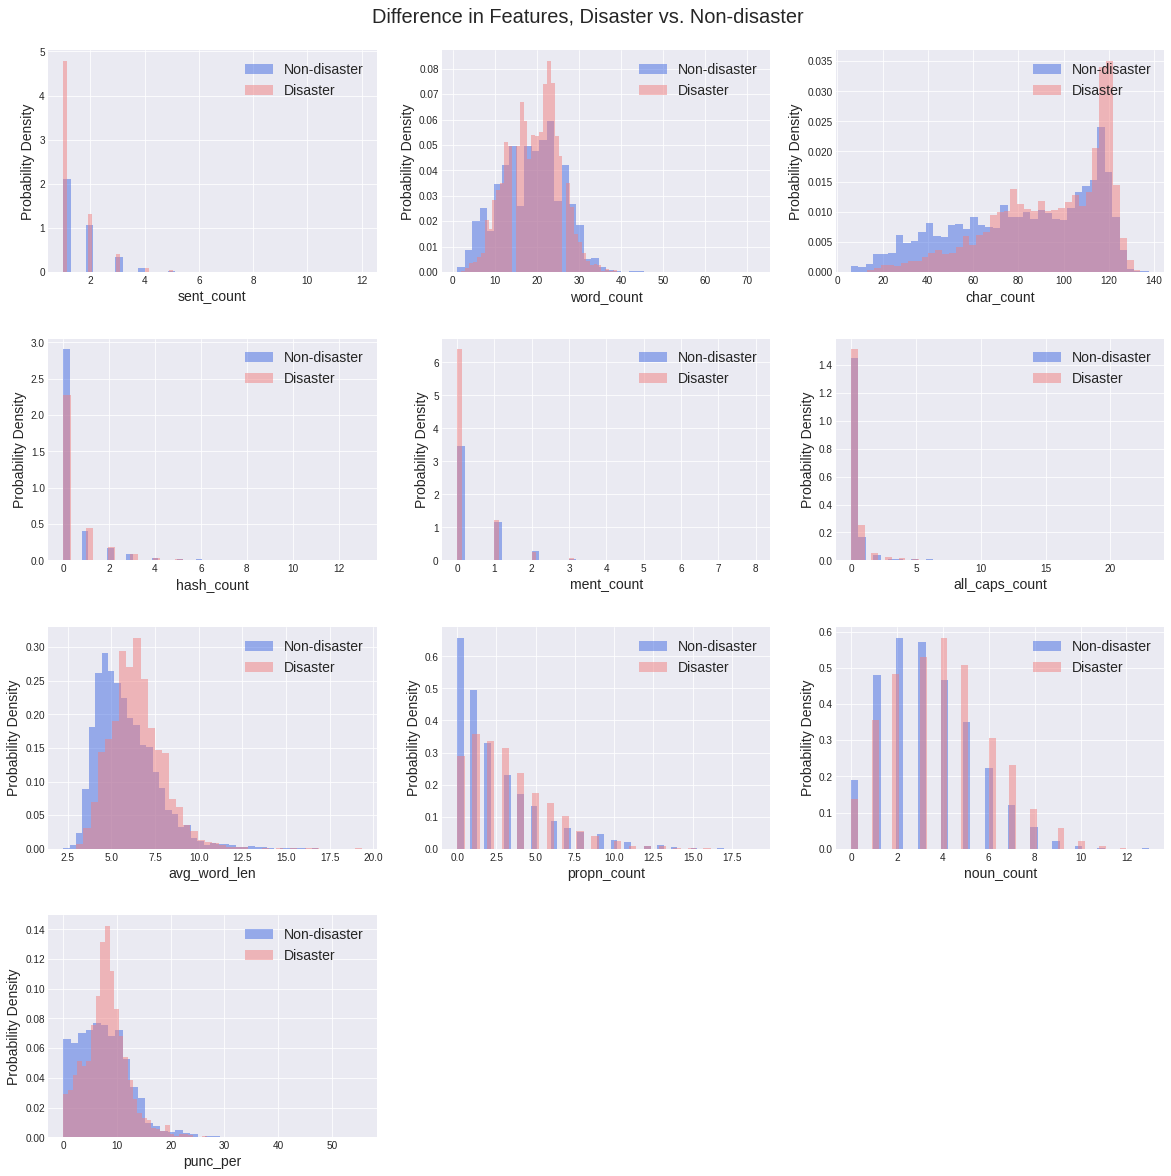

In [62]:
# store the features and their names in variables
features = ['sent_count', 'word_count', 'char_count', 'hash_count', 'ment_count', 'all_caps_count', 
            'avg_word_len', 'propn_count', 'noun_count', 'punc_per']

# create the figure
fig = plt.figure(figsize=(20, 20))

# adjust the height of the padding between subplots to avoid overlapping
plt.subplots_adjust(hspace=0.3)

# add a centered suptitle to the figure
plt.suptitle("Difference in Features, Disaster vs. Non-disaster", fontsize=20, y=0.91)

# generate the histograms in a for loop
for i, feature in enumerate(features):
    
    # add a new subplot iteratively
    ax = plt.subplot(4, 3, i+1)
    ax = df_train[df_train['target']==0][feature].hist(alpha=0.5, label='Non-disaster', bins=40, color='royalblue', density=True)
    ax = df_train[df_train['target']==1][feature].hist(alpha=0.5, label='Disaster', bins=40, color='lightcoral', density=True)
    
    # set x_label, y_label, and legend
    ax.set_xlabel(features[i], fontsize=14)
    ax.set_ylabel('Probability Density', fontsize=14)
    ax.legend(loc='upper right', fontsize=14)
    

# shot the figure
plt.show()

- We'll use the four features, **word_count, char_count, avg_word_len, and punc_per**, for our models as they show bigger differences in distributions than other features we've created.
- Note: The y-axis in the plots above is probability density, not # of Tweets due to the different size of disaster/non-disaster Tweets. 

Now let's move on and start building our models!

***

# <a id=""> Features extraction</a>

## Vectorizing Text

In [63]:
# import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# instantiate the vectorizer
tfidf = TfidfVectorizer(stop_words='english', max_df=0.5, min_df=1)

# fit and transform
tif = tfidf.fit(df_train['text_cleaned'])
X_tfidf=tif.transform(df_train['text_cleaned'])

In [64]:
# create a dataframe from the sparse matrix
X_tfidf_df = pd.DataFrame(X_tfidf.toarray())

# check the dataframe
X_tfidf_df.head()

,0,1,2,3,4,5,6,7,8,9,...,11972,11973,11974,11975,11976,11977,11978,11979,11980,11981
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:

vocab_size=tfidf.get_feature_names_out().shape[0]

In [66]:
# get the feature names from our stored vectorizer and assign them to X_tfidf_df
# to avoid getting 'FutureWarning: Feature names only support names that are strings.'
X_tfidf_df.columns = tfidf.get_feature_names_out()

# check the column names
X_tfidf_df.columns

Index(['__', 'aa', 'aan', 'aand', 'aar', 'aashiqui', 'ab', 'aba', 'abandon',
       'abandoned',
       ...
       'zombie', 'zone', 'zones', 'zoom', 'zotar', 'zouma', 'zrnf', 'zss',
       'zumiez', 'zurich'],
      dtype='object', length=11982)

In [67]:
X_tfidf_df.shape, df_train.shape

((7543, 11982), (7543, 16))

In [68]:
X_tfidf_df[['word_count', 'char_count', 'avg_word_len', 'punc_per']]=df_train[['word_count', 'char_count', 'avg_word_len', 'punc_per']]

In [69]:
# create the new dataframe, X_features
#= pd.concat([df_train[['word_count', 'char_count', 'avg_word_len', 'punc_per']], X_tfidf_df], axis=1)

# check the shape
X_features= X_tfidf_df
X_features.shape

(7543, 11986)

In [70]:
# check the dataframe
X_features.head()

,__,aa,aan,aand,aar,aashiqui,ab,aba,abandon,abandoned,...,zotar,zouma,zrnf,zss,zumiez,zurich,word_count,char_count,avg_word_len,punc_per
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,14.0,57.0,4.38,1.75
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8.0,32.0,4.57,3.12
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,24.0,112.0,5.09,2.68
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,9.0,57.0,7.12,3.51
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,18.0,72.0,4.50,2.78


In [71]:
from sklearn.model_selection import train_test_split
x_train_tf, x_val_tf, y_train_tf, y_val_tf=train_test_split(X_features,df_train['target'],  test_size=0.1, random_state=123)


##  Doc2vec

In [72]:
#Import all the dependencies
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [73]:
data=df_train['text_cleaned'].tolist()
tagged_data = [TaggedDocument(words=word_tokenize(d), tags=[str(i)]) for i, d in enumerate(data)]

In [74]:
tagged_data[0]

TaggedDocument(words=['deed', 'reason', 'earthquake', 'allah', 'forgive'], tags=['0'])

In [75]:
max_epochs = 100
vec_size = 20
alpha = 0.025

model = Doc2Vec(#size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm=0
                )
  
vocab=model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=1)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("d2v.model")
print("Model Saved")

iteration 0


iteration 1


iteration 2


iteration 3


iteration 4


iteration 5


iteration 6


iteration 7


iteration 8


iteration 9


iteration 10


iteration 11


iteration 12


iteration 13


iteration 14


iteration 15


iteration 16


iteration 17


iteration 18


iteration 19


iteration 20


iteration 21


iteration 22


iteration 23


iteration 24


iteration 25


iteration 26


iteration 27


iteration 28


iteration 29


iteration 30


iteration 31


iteration 32


iteration 33


iteration 34


iteration 35


iteration 36


iteration 37


iteration 38


iteration 39


iteration 40


iteration 41


iteration 42


iteration 43


iteration 44


iteration 45


iteration 46


iteration 47


iteration 48


iteration 49


iteration 50


iteration 51


iteration 52


iteration 53


iteration 54


iteration 55


iteration 56


iteration 57


iteration 58


iteration 59


iteration 60


iteration 61


iteration 62


iteration 63


iteration 64


iteration 65


iteration 66


iteration 67


iteration 68


iteration 69


iteration 70


iteration 71


iteration 72


iteration 73


iteration 74


iteration 75


iteration 76


iteration 77


iteration 78


iteration 79


iteration 80


iteration 81


iteration 82


iteration 83


iteration 84


iteration 85


iteration 86


iteration 87


iteration 88


iteration 89


iteration 90


iteration 91


iteration 92


iteration 93


iteration 94


iteration 95


iteration 96


iteration 97


iteration 98


iteration 99


Model Saved


In [76]:
doc_data=[]
for i in range(len(tagged_data)):
  doc_data.append(model.infer_vector(tagged_data[i].words))
doc_df=pd.DataFrame(doc_data)
doc_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.002671,-0.013938,-0.002306,-0.009692,0.016702,0.012870,0.016330,0.010423,0.013950,0.003004,...,0.024148,0.015213,-0.021841,0.013715,-0.005767,0.007531,0.000350,-0.004296,0.003469,0.016160
1,-0.001862,-0.023862,-0.008151,-0.000994,0.013673,-0.002422,0.030008,-0.005985,0.011767,-0.004005,...,0.018086,0.020076,-0.021298,0.020375,0.011751,0.019502,-0.007084,-0.019694,0.009796,0.003820
2,-0.012431,-0.057285,-0.026106,0.020399,0.031340,0.011255,0.040662,0.018954,0.023757,0.014061,...,0.058772,0.019186,-0.030090,0.033784,0.013364,0.017339,0.019543,-0.020496,0.019682,0.016129
3,0.003006,-0.021050,-0.008683,-0.001035,0.020931,0.007115,0.028014,-0.002684,0.011862,-0.004147,...,0.018131,0.007527,-0.006149,0.012404,0.001366,0.007906,0.012882,-0.013729,-0.000854,0.018403
4,-0.007600,-0.021517,-0.022451,-0.005334,0.022792,0.000829,0.041967,-0.001303,0.018972,-0.014071,...,0.037112,0.032239,-0.011987,0.018517,-0.012841,0.016997,0.010609,-0.000906,0.013029,0.018388


In [77]:
doc_df.shape

(7543, 100)

In [78]:
doc_data=[]
for i in range(len(df_test['text_cleaned'].tolist())):
   doc_data.append(model.infer_vector(df_test['text_cleaned'].tolist()[i].split(' ')))
x_test_doc=pd.DataFrame(doc_data)
x_test_doc.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.000473,-0.003508,-0.012470,-0.011531,0.020147,-0.000252,0.006497,-0.003987,0.002824,-0.001223,...,0.016849,0.011206,-0.016161,-0.001778,0.006360,0.010785,0.001659,-0.004126,0.015654,0.011386
1,0.002099,-0.018944,-0.008607,-0.011237,0.012390,0.001375,0.027169,-0.009180,0.006681,0.006254,...,0.026917,0.018041,-0.015269,0.027895,-0.002880,0.011017,0.000613,-0.020333,0.003029,0.019896
2,0.007363,-0.019897,-0.027917,-0.006395,0.020099,-0.008468,0.030023,-0.003135,0.001824,0.007101,...,0.035595,0.018277,-0.024254,0.019667,0.012653,0.006881,0.005681,-0.006304,0.007743,0.003112
3,0.001271,-0.018511,0.003011,-0.005825,0.009084,0.005554,0.015568,0.004171,0.006713,-0.000959,...,0.020389,0.016877,-0.002806,0.003077,-0.000080,0.004859,0.005832,0.001413,0.002551,-0.002961
4,-0.011350,-0.023573,-0.007600,0.005033,0.023539,0.006573,0.018446,0.016887,0.011152,-0.005897,...,0.014424,0.009727,-0.008862,0.002145,0.006173,0.014001,0.009501,-0.017276,0.001708,-0.004079


In [79]:
from sklearn.model_selection import train_test_split
x_train_doc, x_val_doc, y_train_doc, y_val_doc=train_test_split(doc_df,df_train['target'],  test_size=0.1, random_state=123)


In [80]:
'''x_train_doc = tf.keras.preprocessing.sequence.pad_sequences(x_train_doc)
y_train_doc=np.array(y_train_doc.tolist())
y_val_doc=np.array(y_val_doc.tolist())'''

'x_train_doc = tf.keras.preprocessing.sequence.pad_sequences(x_train_doc)\ny_train_doc=np.array(y_train_doc.tolist())\ny_val_doc=np.array(y_val_doc.tolist())'

# Modélisation


## Logistic Regressor

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Model:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
l_model=LogisticRegression()
#l_model = MultiOutputClassifier(l_model)
def clean_dataset(df, y):
    df['y']=y.values
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    df=df[indices_to_keep].astype(np.float64)
    y=df['y']
    df.drop(columns=['y'], inplace=True)
    return df, y

def clean_test_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    df=df[indices_to_keep].astype(np.float64)
    return df

def logistic_regressor(x_train, y_train):
    n_jobs=[-1]

    hyperparameters = {"C": [0.5, 1], 
        "l1_ratio": [0.5, 1],
        "max_iter": [100,300, 1000], 
                          'n_jobs': n_jobs,
              
                          }
    print(GridSearchCV(l_model, param_grid={}, scoring='accuracy').get_params())
    x_train, y_train=clean_dataset(x_train, y_train)
    grid = GridSearchCV(l_model, hyperparameters, cv=KFold(4,shuffle=True, random_state=123), scoring='accuracy', verbose=2)
    grid.fit(x_train, y_train)
    return grid

### Tfidf

In [ ]:
from sklearn.metrics import accuracy_score
model_tf=logistic_regressor(x_train_tf, y_train_tf)


{'cv': None, 'error_score': nan, 'estimator__C': 1.0, 'estimator__class_weight': None, 'estimator__dual': False, 'estimator__fit_intercept': True, 'estimator__intercept_scaling': 1, 'estimator__l1_ratio': None, 'estimator__max_iter': 100, 'estimator__multi_class': 'auto', 'estimator__n_jobs': None, 'estimator__penalty': 'l2', 'estimator__random_state': None, 'estimator__solver': 'lbfgs', 'estimator__tol': 0.0001, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': LogisticRegression(), 'n_jobs': None, 'param_grid': {}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': 'accuracy', 'verbose': 0}
Fitting 4 folds for each of 12 candidates, totalling 48 fits
[CV] END .......C=0.5, l1_ratio=0.5, max_iter=100, n_jobs=-1; total time=  12.9s
[CV] END .......C=0.5, l1_ratio=0.5, max_iter=100, n_jobs=-1; total time=  13.5s
[CV] END .......C=0.5, l1_ratio=0.5, max_iter=100, n_jobs=-1; total time=  12.5s
[CV] END .......C=0.5, l1_ratio=0.5, max_ite

In [ ]:
x_val_tf, y_val_tf=clean_dataset(x_val_tf, y_val_tf)
score=model_tf.score(x_val_tf, y_val_tf)
print("validation_score: ", score)

validation_score:  0.7809139784946236


In [ ]:
x_test_tf=tif.transform(df_test['text_cleaned']).toarray()
x_test_tf=pd.DataFrame(x_test_tf)
x_test_tf[['word_count', 'char_count', 'avg_word_len', 'punc_per']]=df_test[['word_count', 'char_count', 'avg_word_len', 'punc_per']]
x_test_tf=clean_test_dataset(x_test_tf)
pred=model_tf.predict(x_test_tf)
print("accuracy: ", accuracy_score(model_tf.predict(x_val_tf), y_val_tf))


accuracy:  0.7809139784946236


In [ ]:
pred=[int(i) for i in pred]

In [ ]:
df_test['target']=pred
df_submit['target']=pred
df_submit.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [ ]:
df_test[['text_cleaned', "target"]]

,text_cleaned,target
0,happen terrible car crash,1
1,hear earthquake different city stay safe,1
2,forest fire spot pond geese flee street save,1
3,apocalypse lighting spokane wildfire,1
4,typhoon soudelor kill china taiwan,1
...,...,...
3258,earthquake safety los angeles safety fastener ...,1
3259,storm ri bad hurricane hard hit yard look like...,1
3260,green line derailment chicago,1
3261,meg issue hazardous weather outlook hwo,1


In [ ]:
df_test.target.describe()

count    3263.000000
mean        0.342017
std         0.474458
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: target, dtype: float64

In [ ]:
df_submit.to_csv('sample_submission.csv', index=False)

In [ ]:
#with adding df  columns

### Doc2vec

In [ ]:
from sklearn.metrics import accuracy_score
model_doc=logistic_regressor(x_train_doc, y_train_doc)

{'cv': None, 'error_score': nan, 'estimator__C': 1.0, 'estimator__class_weight': None, 'estimator__dual': False, 'estimator__fit_intercept': True, 'estimator__intercept_scaling': 1, 'estimator__l1_ratio': None, 'estimator__max_iter': 100, 'estimator__multi_class': 'auto', 'estimator__n_jobs': None, 'estimator__penalty': 'l2', 'estimator__random_state': None, 'estimator__solver': 'lbfgs', 'estimator__tol': 0.0001, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': LogisticRegression(), 'n_jobs': None, 'param_grid': {}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': 'accuracy', 'verbose': 0}

Fitting 4 folds for each of 12 candidates, totalling 48 fits

[CV] END .......C=0.5, l1_ratio=0.5, max_iter=100, n_jobs=-1; total time=   1.1s

[CV] END .......C=0.5, l1_ratio=0.5, max_iter=100, n_jobs=-1; total time=   1.1s

[CV] END .......C=0.5, l1_ratio=0.5, max_iter=100, n_jobs=-1; total time=   1.1s

[CV] END .......C=0.5, l1_ratio=0.5, ma

In [ ]:
score=model_doc.score(x_val_doc, y_val_doc)
score

0.6503311258278146

In [ ]:
print("accuracy: ", accuracy_score(model_doc.predict(x_val_doc), y_val_doc))
pred_doc=model_doc.predict(x_test_doc)


accuracy:  0.6503311258278146


In [ ]:
pred_doc=[int(i) for i in pred_doc]
np.unique(pred_doc)

array([0, 1])

In [ ]:
df_test['target']=pred_doc
df_submit['target']=pred_doc
df_submit.head()
df_submit.to_csv('sample_submission.csv', index=False)

## Transformers

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dropout, Layer
from tensorflow.keras.layers import Embedding, Input, GlobalAveragePooling1D, Dense
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential, Model
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [ ]:
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [Dense(ff_dim, activation="relu"), 
             Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train['text_cleaned'])
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)


def transformer_model(x_train, y_train, x_val, y_val ):
  maxlen=x_train.shape[1]
  embed_dim = 32  # Embedding size for each token
  num_heads = 2  # Number of attention heads
  ff_dim = 32  # Hidden layer size in feed forward network inside transformer
  vocab_size = x_train.shape[1]  # Only consider the top 20k words
  maxlen = x_train.shape[1]
  inputs = Input(shape=(maxlen,))
  embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
  x = embedding_layer(inputs)
  transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
  x = transformer_block(x)
  x = GlobalAveragePooling1D()(x)
  x = Dropout(0.1)(x)
  x = Dense(20, activation="relu")(x)
  x = Dropout(0.1)(x)
  outputs = Dense(2,  activation="softmax")(x)

  model = Model(inputs=inputs, outputs=outputs)

  model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

  history = model.fit(x_train, y_train, 
                      batch_size=64, epochs=5, 
                      validation_data=(x_val, y_val)
                    )
  results = model.evaluate(x_val, y_val, verbose=2)

  for name, value in zip(model.metrics_names, results):
      print("%s: %.3f" % (name, value))
  return model, history

12148


### Tfidf Vectorizer

In [ ]:
# instantiate the vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
tfidf = TfidfVectorizer(stop_words='english', max_features=2000)

# fit and transform
tif = tfidf.fit(df_train['text_cleaned'])
X_tfidf=tif.transform(df_train['text_cleaned'])
dftf=pd.DataFrame(X_tfidf.toarray())
x_train_tf, x_val_tf, y_train_tf, y_val_tf=train_test_split(dftf, df_train['target'], test_size=0.2)

In [ ]:
x_test_tf=pd.DataFrame(tfidf.transform(df_test['text_cleaned']).toarray())

In [ ]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train_tf.values, maxlen=2000)
x_val = tf.keras.preprocessing.sequence.pad_sequences(x_val_tf.values, maxlen=2000)
y_train_tf=np.array(y_train_tf)
y_val_df=np.array(y_val_tf)


In [ ]:
model_tf1, history=transformer_model(x_train, y_train_tf, x_val, y_val_tf)

2022-12-11 05:50:25.094253: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-11 05:50:25.095420: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-11 05:50:25.096073: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-11 05:50:25.096880: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Epoch 1/5
95/95 [==============================] - 19s 178ms/step - loss: 0.6951 - accuracy: 0.5484 - val_loss: 0.6839 - val_accuracy: 0.5693
Epoch 2/5
95/95 [==============================] - 16s 172ms/step - loss: 0.6851 - accuracy: 0.5678 - val_loss: 0.6837 - val_accuracy: 0.5693
Epoch 3/5
95/95 [==============================] - 16s 173ms/step - loss: 0.6846 - accuracy: 0.5689 - val_loss: 0.6844 - val_accuracy: 0.5693
Epoch 4/5
95/95 [==============================] - 17s 174ms/step - loss: 0.6843 - accuracy: 0.5728 - val_loss: 0.6836 - val_accuracy: 0.5693
Epoch 5/5
95/95 [==============================] - 16s 173ms/step - loss: 0.6838 - accuracy: 0.5723 - val_loss: 0.6838 - val_accuracy: 0.5693
48/48 - 1s - loss: 0.6838 - accuracy: 0.5693
loss: 0.684
accuracy: 0.569


In [ ]:
pred=model_tf1.predict(x_test_tf)
pred=[round(i[0]) for i in pred]

In [ ]:
df_submit['target']=pred
df_submit.to_csv('sample_submission.csv', index=False)

### Doc2vec

In [ ]:
x_train_ = tf.keras.preprocessing.sequence.pad_sequences(x_train_doc.values, maxlen=100)
x_val = tf.keras.preprocessing.sequence.pad_sequences(x_val_doc.values, maxlen=100)
y_train=np.array(y_train_doc)
y_val=np.array(y_val_doc)

In [ ]:
model_doc2, history=transformer_model(x_train_, y_train, x_val, y_val)

Epoch 1/5
107/107 [==============================] - 2s 11ms/step - loss: 0.6939 - accuracy: 0.5492 - val_loss: 0.6898 - val_accuracy: 0.5576
Epoch 2/5
107/107 [==============================] - 1s 7ms/step - loss: 0.6859 - accuracy: 0.5701 - val_loss: 0.6877 - val_accuracy: 0.5576
Epoch 3/5
107/107 [==============================] - 1s 7ms/step - loss: 0.6839 - accuracy: 0.5734 - val_loss: 0.6865 - val_accuracy: 0.5576
Epoch 4/5
107/107 [==============================] - 1s 7ms/step - loss: 0.6837 - accuracy: 0.5734 - val_loss: 0.6896 - val_accuracy: 0.5576
Epoch 5/5
107/107 [==============================] - 1s 7ms/step - loss: 0.6831 - accuracy: 0.5754 - val_loss: 0.6867 - val_accuracy: 0.5576
24/24 - 0s - loss: 0.6867 - accuracy: 0.5576
loss: 0.687
accuracy: 0.558


In [ ]:
pred_doc=model_doc2.predict(x_test_doc)
pred_doc=[round(i[0]) for i in pred_doc]

In [ ]:
df_submit['target']=pred_doc
df_submit.to_csv('sample_submission.csv', index=False)

## Model Pré-entrainé

In [81]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np
import os

In [82]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)
                           

model = Sequential()
model.add(hub_layer)
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dense (Dense)               (None, 16)                816       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________


In [83]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
              
history = model.fit(df_train['text_cleaned'], df_train['target'], 
                    epochs=5,
                    validation_split=0.1,
                    verbose=1)

Epoch 1/5


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


213/213 [==============================] - 10s 33ms/step - loss: 0.5877 - accuracy: 0.7030 - val_loss: 0.4825 - val_accuracy: 0.7907
Epoch 2/5
213/213 [==============================] - 7s 32ms/step - loss: 0.3846 - accuracy: 0.8365 - val_loss: 0.4629 - val_accuracy: 0.7894
Epoch 3/5
213/213 [==============================] - 7s 31ms/step - loss: 0.2797 - accuracy: 0.8911 - val_loss: 0.4955 - val_accuracy: 0.7775
Epoch 4/5
213/213 [==============================] - 7s 31ms/step - loss: 0.2044 - accuracy: 0.9250 - val_loss: 0.5552 - val_accuracy: 0.7748
Epoch 5/5
213/213 [==============================] - 7s 31ms/step - loss: 0.1515 - accuracy: 0.9478 - val_loss: 0.6051 - val_accuracy: 0.7775


In [84]:
pred=model.predict(df_test['text_cleaned'])

102/102 [==============================] - 0s 4ms/step


In [85]:
pred=[round(i[0]) for i in pred]
print(pred)

[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 

In [86]:
df_test['target']=pred

In [87]:
df_submit['target']=pred
df_submit.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [88]:
df_submit.to_csv('sample_submission.csv', index=False)

In [89]:
df_test[df_test['target']==0]['text_cleaned']

6                   probably life arsenal yesterday eh eh
7                                                     hey
8                                                nice hat
9                                                    fuck
10                                              like cold
                              ...                        
3247    rt cnbc word disney ceo bob iger wreck disney ...
3248               smackdown tyme good mood got wreck smh
3249    jsyk stop think abt remus slump bathroom door ...
3250    begovic garbage got wreck red bull reserve tea...
3256    conference attendee blue line airport derail l...
Name: text_cleaned, Length: 1996, dtype: object